# K‑Fold Model Comparison Dashboard

*Generated: 2025-08-19 15:37*

This notebook loads k‑fold training histories for **multiple models**, extracts the **best epoch per fold** (based on `val_accuracy` by default), and provides **publication‑quality** comparisons:

- Summary tables per model and combined
- Boxplot of validation accuracy across folds (per model)
- Mean±SD bar charts for validation accuracy and overfitting gap
- CSV export of all summarized results

> **Assumptions:** Each fold's history is stored as a NumPy `.npy` (dict-like) with keys at least: `accuracy`, `loss`, `val_accuracy`, `val_loss`. Filenames contain `fold_{i}` so the fold number can be parsed.


In [1]:

import glob
import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 200)
pd.set_option("display.float_format", "{:.4f}".format)


/var/folders/by/b05bkcn50tb0fx4h3hhz0h800000gn/T/ipykernel_62223/874667086.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## 1) Configure your models and file patterns

Edit the dictionary below so that each **key** is a human‑readable model name and each **value** is a **glob pattern** that matches all fold history files for that model.

**Examples**
- `"/home/lennart/work/logs/ModelA/fold_*/*history.npy"`
- `"/home/lennart/work/logs/ResNet/kfold_*/*.npy"`

> The pattern must include `fold_` followed by a number (e.g., `fold_1`), which is used to map results to each fold.


In [2]:

# === EDIT ME: map model names to their glob patterns ===
MODEL_PATTERNS = {
    "Baseline Conv": '/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/training_histories_06_25/control_conv/2_classes_training/control_conv/conv_00_2cls_slice_no_clin_no_layer_gray_seq[[]t1c[]]_normal_DA_kfold_run_2025_07_30_14_14_03/history_conv_00_2cls_slice_no_clin_no_layer_gray_seq[[]t1c[]]_normal_DA_kfold_fold_*_run_2025_07_30_14_14_03.npy',
    "ResNet34": "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/training_histories_06_25/ResNet34/2_classes_training/control/resnet34_00_2cls_slice_no_clin_no_layer_gray_seq[[]t1c[]]_normal_DA_kfold_run_2025_07_30_19_52_45/history_resnet34_00_2cls_slice_no_clin_no_layer_gray_seq[[]t1c[]]_normal_DA_kfold_fold_*_run_2025_07_30_19_52_45.npy",
    "ResNeXt50": '/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/training_histories_06_25/ResNeXt50/2_classes_training/control/resnext50_00_2cls_slice_no_clin_no_layer_gray_seq[[]t1c[]]_normal_DA_kfold_run_2025_07_31_12_48_20/history_resnext50_00_2cls_slice_no_clin_no_layer_gray_seq[[]t1c[]]_normal_DA_kfold_fold_*_run_2025_07_31_12_48_20.npy',
    "ResNeXt101": "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/training_histories_06_25/ResNeXt101/2_classes_training/control/resnext101_00_2cls_slice_no_clin_no_layer_gray_seq[[]t1c[]]_normal_DA_kfold_run_2025_08_01_14_38_29/history_resnext101_00_2cls_slice_no_clin_no_layer_gray_seq[[]t1c[]]_normal_DA_kfold_fold_*_run_2025_08_01_14_38_29.npy",
    "ResNet152": '/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/training_histories_06_25/ResNet152/2_classes_training/control/resnet152_00_2cls_slice_no_clin_no_layer_gray_seq[[]t1c[]]_normal_DA_kfold_run_2025_08_17_19_31_38/history_resnet152_00_2cls_slice_no_clin_no_layer_gray_seq[[]t1c[]]_normal_DA_kfold_fold_*_run_2025_08_17_19_31_38.npy',
    "InceptionV3": '/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/training_histories_06_25/transfer_inceptionv3/2_classes_training/control/transfer_inceptionv3_00_2cls_slice_no_clin_no_layer_rgb_seq[[]t1c[]]_normal_DA_kfold_run_2025_09_01_16_03_27/history_transfer_inceptionv3_00_2cls_slice_no_clin_no_layer_rgb_seq[[]t1c[]]_normal_DA_kfold_fold_*_run_2025_09_01_16_03_27.npy'
}

# Metric used to pick the best epoch within each fold
SELECTION_METRIC = "val_accuracy"  # change to "val_loss" if desired
HIGHER_IS_BETTER = True            # set False if using "val_loss" or any metric where lower is better


## 2) Helpers: load and summarize each model

In [3]:

def _extract_fold_number(path: str):
    m = re.search(r"fold_(\d+)", str(path))
    return int(m.group(1)) if m else None


def summarize_single_model(path_pattern: str,
                           selection_metric: str = "val_accuracy",
                           higher_is_better: bool = True) -> pd.DataFrame:
    """Load all fold histories for one model and summarize at the best epoch per fold."""
    files = sorted(glob.glob(path_pattern))
    rows = []
    for f in files:
        fold_num = _extract_fold_number(f)
        if fold_num is None:
            continue

        try:
            history = np.load(f, allow_pickle=True).item()
            df = pd.DataFrame(history)

            if selection_metric not in df.columns:
                print(f"[WARN] {selection_metric} not found in {f}. Skipping.")
                continue

            if higher_is_better:
                best_idx = df[selection_metric].idxmax()
            else:
                best_idx = df[selection_metric].idxmin()

            row = {
                "Fold": fold_num,
                "Best Epoch": int(best_idx) + 1,
                "Val Accuracy": float(df.get("val_accuracy", pd.Series([np.nan])).iloc[best_idx]),
                "Val Loss": float(df.get("val_loss", pd.Series([np.nan])).iloc[best_idx]),
                "Train Accuracy": float(df.get("accuracy", pd.Series([np.nan])).iloc[best_idx]),
                "Train Loss": float(df.get("loss", pd.Series([np.nan])).iloc[best_idx]),
            }
            row["Overfitting Gap (Acc)"] = row["Train Accuracy"] - row["Val Accuracy"]
            rows.append(row)
        except Exception as e:
            print(f"[ERROR] Could not process {f}: {e}")

    if not rows:
        return pd.DataFrame(columns=[
            "Fold", "Best Epoch", "Val Accuracy", "Val Loss", "Train Accuracy", "Train Loss", "Overfitting Gap (Acc)"
        ])

    out = pd.DataFrame(rows).sort_values("Fold").reset_index(drop=True)
    return out


def summarize_all_models(model_patterns: dict,
                         selection_metric: str = "val_accuracy",
                         higher_is_better: bool = True):
    """Return two DataFrames:
       - per_model_results: dict of model_name -> fold-wise summary DataFrame
       - combined: one DataFrame with a 'Model' column added
    """
    per_model = {}
    combined_rows = []
    for model_name, pattern in model_patterns.items():
        df = summarize_single_model(pattern, selection_metric, higher_is_better)
        per_model[model_name] = df
        if len(df):
            tmp = df.copy()
            tmp.insert(0, "Model", model_name)
            combined_rows.append(tmp)

    combined = pd.concat(combined_rows, ignore_index=True) if combined_rows else pd.DataFrame()
    return per_model, combined


## 3) Run the summary

In [4]:

per_model_results, combined = summarize_all_models(
    MODEL_PATTERNS,
    selection_metric=SELECTION_METRIC,
    higher_is_better=HIGHER_IS_BETTER
)

if combined.empty:
    print("No results found. Please check your MODEL_PATTERNS and file paths.")
else:
    display(combined.sort_values(["Model", "Fold"]).reset_index(drop=True))
    print("\nPer-model descriptive stats (Val Accuracy):\n")
    for name, df in per_model_results.items():
        if df.empty:
            print(f"- {name}: no data")
            continue
        desc = df["Val Accuracy"].describe()[["count","mean","std","min","max"]]
        print(f"\n{name}\n{desc}")


,Model,Fold,Best Epoch,Val Accuracy,Val Loss,Train Accuracy,Train Loss,Overfitting Gap (Acc)
0,Baseline Conv,0,15,0.6031,0.9931,0.4854,1.0439,-0.1177
1,Baseline Conv,1,298,0.7069,0.9749,0.7033,0.8651,-0.0036
2,Baseline Conv,2,329,0.7377,1.0586,0.7193,0.8406,-0.0184
3,Baseline Conv,3,30,0.8172,0.9201,0.5040,1.0273,-0.3132
4,Baseline Conv,4,692,0.6693,1.3071,0.8923,0.5505,0.2230
5,Baseline Conv,5,477,0.7722,0.8422,0.8254,0.6759,0.0532
6,Baseline Conv,6,143,0.7778,0.8754,0.6204,0.9560,-0.1574
7,Baseline Conv,7,218,0.7315,0.8801,0.6513,0.9264,-0.0802
8,Baseline Conv,8,258,0.7143,1.2212,0.6621,0.9258,-0.0522
9,Baseline Conv,9,5,0.7089,0.9708,0.4934,1.1386,-0.2155



Per-model descriptive stats (Val Accuracy):


Baseline Conv
count   10.0000
mean     0.7239
std      0.0600
min      0.6031
max      0.8172
Name: Val Accuracy, dtype: float64

ResNet34
count   10.0000
mean     0.7281
std      0.0448
min      0.6457
max      0.7957
Name: Val Accuracy, dtype: float64

ResNeXt50
count   10.0000
mean     0.7566
std      0.0266
min      0.7252
max      0.7929
Name: Val Accuracy, dtype: float64

ResNeXt101
count   10.0000
mean     0.7432
std      0.0289
min      0.7023
max      0.7957
Name: Val Accuracy, dtype: float64

ResNet152
count   10.0000
mean     0.7480
std      0.0315
min      0.7008
max      0.8011
Name: Val Accuracy, dtype: float64

InceptionV3
count   10.0000
mean     0.6945
std      0.0613
min      0.5827
max      0.7500
Name: Val Accuracy, dtype: float64


## 4) Boxplot: Validation Accuracy across folds (per model)

This figure shows the **distribution** of validation accuracies across folds for each model. Use it to visually compare model stability and central tendency.


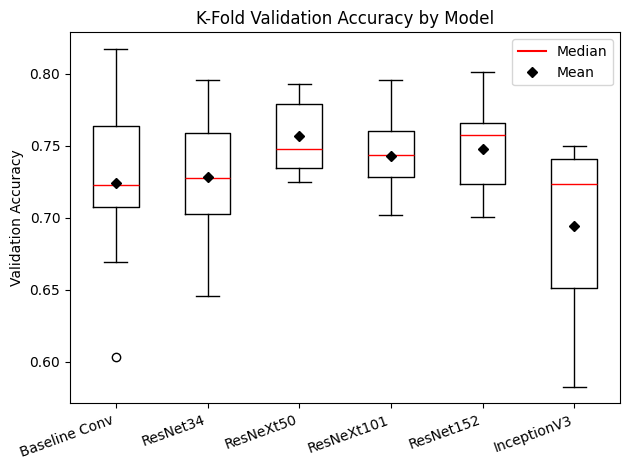

In [6]:

if not combined.empty:
    models = list(per_model_results.keys())
    data = [per_model_results[m]["Val Accuracy"].dropna().values for m in models if not per_model_results[m].empty]

    plt.figure()
    plt.boxplot(data,
                showmeans=True,
                medianprops = dict(color="red"),
                meanprops = dict(marker="D", markerfacecolor="black", markeredgecolor="black", markersize=5))
    plt.xticks(range(1, len(models) + 1), models, rotation=20, ha="right")
    plt.ylabel("Validation Accuracy")
    plt.title("K-Fold Validation Accuracy by Model")
    plt.tight_layout()
    median_handle = plt.Line2D([], [], color="red", linewidth=1.5, label="Median")
    mean_handle   = plt.Line2D([], [], marker="D", linestyle="None",
                           markerfacecolor="black", markeredgecolor="black",
                           markersize=5, label="Mean")
    plt.legend(handles=[median_handle, mean_handle])
    plt.show()


## 5) Mean ± SD: Validation Accuracy

Bars show the mean validation accuracy per model with standard‑deviation error bars (across folds).

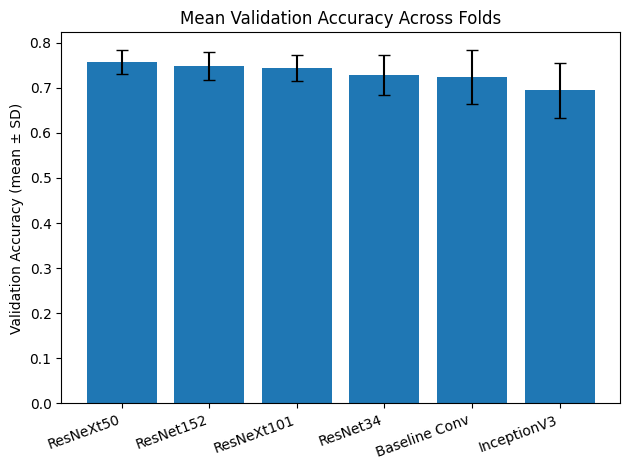

,mean,std
Model,,
ResNeXt50,0.7566,0.0266
ResNet152,0.7480,0.0315
ResNeXt101,0.7432,0.0289
ResNet34,0.7281,0.0448
Baseline Conv,0.7239,0.0600
InceptionV3,0.6945,0.0613


In [6]:

if not combined.empty:
    summary = (combined
               .groupby("Model")["Val Accuracy"]
               .agg(["mean","std"])
               .sort_values("mean", ascending=False))

    plt.figure()
    plt.bar(summary.index, summary["mean"], yerr=summary["std"], capsize=4)
    plt.ylabel("Validation Accuracy (mean ± SD)")
    plt.title("Mean Validation Accuracy Across Folds")
    plt.xticks(rotation=20, ha="right")
    plt.tight_layout()
    plt.show()

    display(summary)


## 6) Mean ± SD: Overfitting Gap (Train Acc − Val Acc)

Positive values indicate the model fits training data better than validation (**overfitting**).

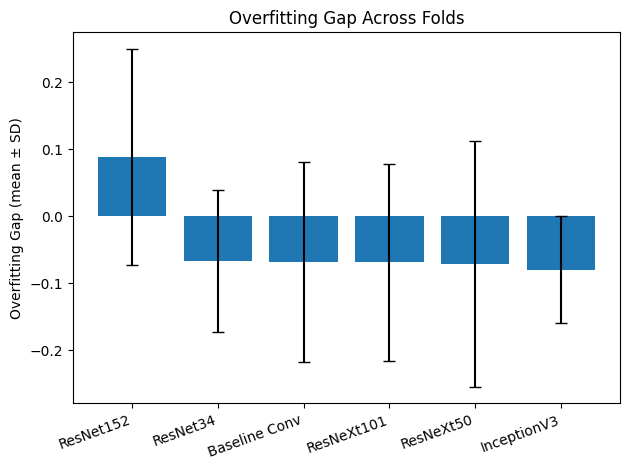

,mean,std
Model,,
ResNet152,0.0882,0.1609
ResNet34,-0.0662,0.1057
Baseline Conv,-0.0682,0.1486
ResNeXt101,-0.0686,0.1471
ResNeXt50,-0.0713,0.1828
InceptionV3,-0.0799,0.0796


In [7]:

if not combined.empty:
    gap = (combined
           .groupby("Model")["Overfitting Gap (Acc)"]
           .agg(["mean","std"])
           .sort_values("mean", ascending=False))

    plt.figure()
    plt.bar(gap.index, gap["mean"], yerr=gap["std"], capsize=4)
    plt.ylabel("Overfitting Gap (mean ± SD)")
    plt.title("Overfitting Gap Across Folds")
    plt.xticks(rotation=20, ha="right")
    plt.tight_layout()
    plt.show()

    display(gap)


## 7) Export combined summary to CSV

In [8]:

if not combined.empty:
    out_path = Path("kfold_combined_summary.csv").resolve()
    combined.to_csv(out_path, index=False)
    print(f"Saved combined summary to: {out_path}")


Saved combined summary to: /Users/LennartPhilipp/Desktop/Uni/Prowiss/Code/Brain_Mets_Classification/notebooks/AI/kfold_combined_summary.csv


---

### Notes
- Replace `MODEL_PATTERNS` with the appropriate paths for your project.
- If your model selection should be based on **minimum validation loss**, set:
  ```python
  SELECTION_METRIC = "val_loss"
  HIGHER_IS_BETTER = False
  ```
- Ensure your history files contain the necessary keys. If not, adapt the code accordingly.
- Each plot uses **matplotlib** only, with one chart per figure and default styling (no custom colors), to be compatible with strict pipelines.
